In [2]:
# 필요한 패키지 import
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
# 글로벌 변수 선언
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # 컬러 사진이므로 채널이 3(rgb)

In [4]:
# 파일명과 정답 설정
filenames = os.listdir("./dogvscat/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [4]:
# 데이터 확인
df.head()

,filename,category
0,cat.10776.jpg,0
1,dog.4009.jpg,1
2,cat.1370.jpg,0
3,cat.1673.jpg,0
4,cat.9051.jpg,0


In [5]:
df.tail()

,filename,category
24988,dog.6403.jpg,1
24989,cat.657.jpg,0
24990,cat.4047.jpg,0
24991,cat.5063.jpg,0
24992,dog.7903.jpg,1


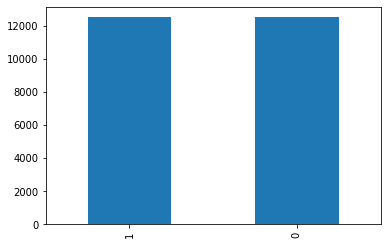

In [7]:
# 데이터 밸런스 확인
df['category'].value_counts().plot.bar()

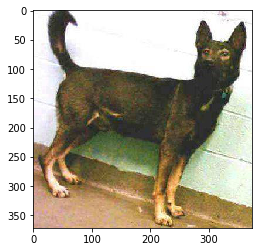

In [9]:
# sample확인하기
sample = random.choice(filenames)
image = load_img('./dogvscat/train/'+sample)
plt.imshow(image)

In [10]:
# 신경망 모델 구성 (cnn)
# 언제나 그렇듯 그냥 잘 나올때까지 계속 바꿔보는것
# 이 밑은 일단 따라해보는 것이다
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='softmax')) # 고양이와 강아지니까 2

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [11]:
# 콜백 정의
# earlystopping? 일정 횟수만큼 정확도가 떨어질때 트리거를 걸어두고 일정 횟수 더 트레이닝을 돌렸더니 또 정확도가 떨어질때 트레이닝을 끝내는 함수
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
# 학습하는 동안 정확도를 감시하다가 어느 기준이 되면 학습율을 조정해주는 클래스
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

#콜백 설정
callbacks = [earlystop,learning_rate_reduction]

In [12]:
# 카테고리 이름을 개,고양이 스트링으로 치환
# 지금이면 고양이 0 강아지 1 이런식으로 분류된다
df['category'] = df['category'].replace({0:'cat',1:'dog'})

In [13]:
# train-validation 데이터 분리
# train데이터 중 일부를 쪼개 (여기서는 20퍼센트)
# 검증을 위한 validation셋을 마련
train_df, validation_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

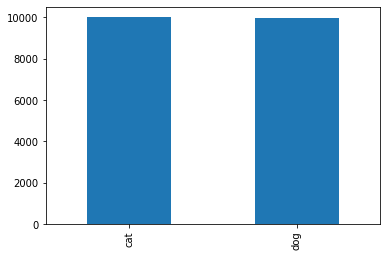

In [14]:
train_df['category'].value_counts().plot.bar()

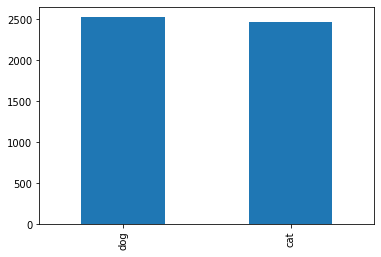

In [15]:
validation_df['category'].value_counts().plot.bar()

In [16]:
# 학습 검증데이터 확인
total_train = train_df.shape[0]
total_validate = validation_df.shape[0]
batch_size = 15 # 한번에 학습할 갯수

In [17]:
# 학습 데이터 뻥튀기
# 부풀리는 방법은 이미지 회전, 줌, 상하/좌우반전 등
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    './dogvscat/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# validation도 마찬가지로 뻥튀기
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    './dogvscat/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19994 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [18]:
# 샘플 확인
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    './dogvscat/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


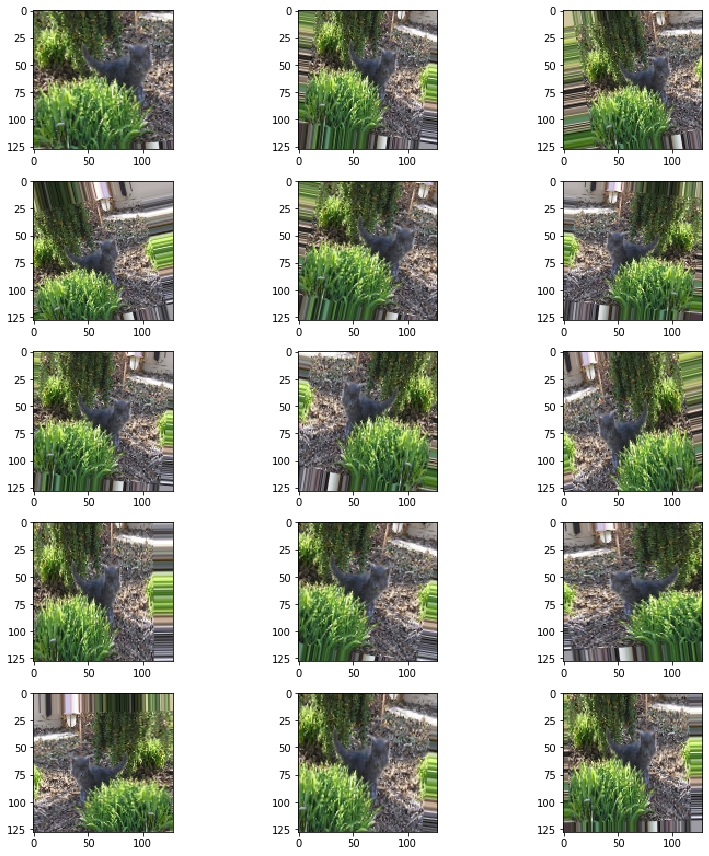

In [19]:
# 이미지 확인하기
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12597126667954297303,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14404997361490249003
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16532652760778874756
 physical_device_desc: "device: XLA_GPU device"]

In [22]:
# # 학습시작
# # 시작 시간: 200913/10:07/PM
# # 끝난 시간: 200914/07:54/AM (돌려두고 잠)
# 싸피 서버 시작 시간: 200914/01:14/PM

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.4287 - accuracy: 0.8047 - val_loss: 0.5684 - val_accuracy: 0.7508
Epoch 2/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.4074 - accuracy: 0.8184 - val_loss: 0.4906 - val_accuracy: 0.7870
Epoch 3/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.3946 - accuracy: 0.8249 - val_loss: 1.2304 - val_accuracy: 0.7313
Epoch 4/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.3909 - accuracy: 0.8281 - val_loss: 0.3820 - val_accuracy: 0.8286
Epoch 5/50
1332/1332 [==============================] - 198s 149ms/step - loss: 0.3718 - accuracy: 0.8358 - val_loss: 0.3564 - val_accuracy: 0.8440
Epoch 6/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.3600 - accuracy: 0.8415 - val_loss: 0.4748 - val_accuracy: 0.7604
Epoch 7/50
1332/1332 [==============================] - 198s 149ms/step - loss: 0.3500 - accuracy: 0.8469 - val_

Epoch 22/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.2920 - accuracy: 0.8769 - val_loss: 0.2198 - val_accuracy: 0.9153
Epoch 23/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.2953 - accuracy: 0.8745 - val_loss: 0.2830 - val_accuracy: 0.8897
Epoch 24/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.2949 - accuracy: 0.8765 - val_loss: 0.2518 - val_accuracy: 0.8957
Epoch 25/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.2988 - accuracy: 0.8746 - val_loss: 0.2643 - val_accuracy: 0.8937
Epoch 26/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.2883 - accuracy: 0.8807 - val_loss: 0.3215 - val_accuracy: 0.8641
Epoch 27/50
1332/1332 [==============================] - 199s 150ms/step - loss: 0.2864 - accuracy: 0.8776 - val_loss: 0.1947 - val_accuracy: 0.9243
Epoch 28/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.2784 - accuracy: 0.8831

Epoch 43/50
1332/1332 [==============================] - 199s 150ms/step - loss: 0.2610 - accuracy: 0.8945 - val_loss: 0.6030 - val_accuracy: 0.7570
Epoch 44/50
1332/1332 [==============================] - 200s 150ms/step - loss: 0.2537 - accuracy: 0.8966 - val_loss: 0.2004 - val_accuracy: 0.9261
Epoch 45/50
1332/1332 [==============================] - 199s 149ms/step - loss: 0.2650 - accuracy: 0.8929 - val_loss: 0.2543 - val_accuracy: 0.8997


In [27]:
print(history)

In [30]:
model_json = model.to_json()
with open('CNN_dog_cat_model.json','w') as json_file:
    json_file.write(model_json)

model.save_weights('CNN_dog_cat_model.h5')
print('Saved model to disk')

Saved model to disk


No handles with labels found to put in legend.


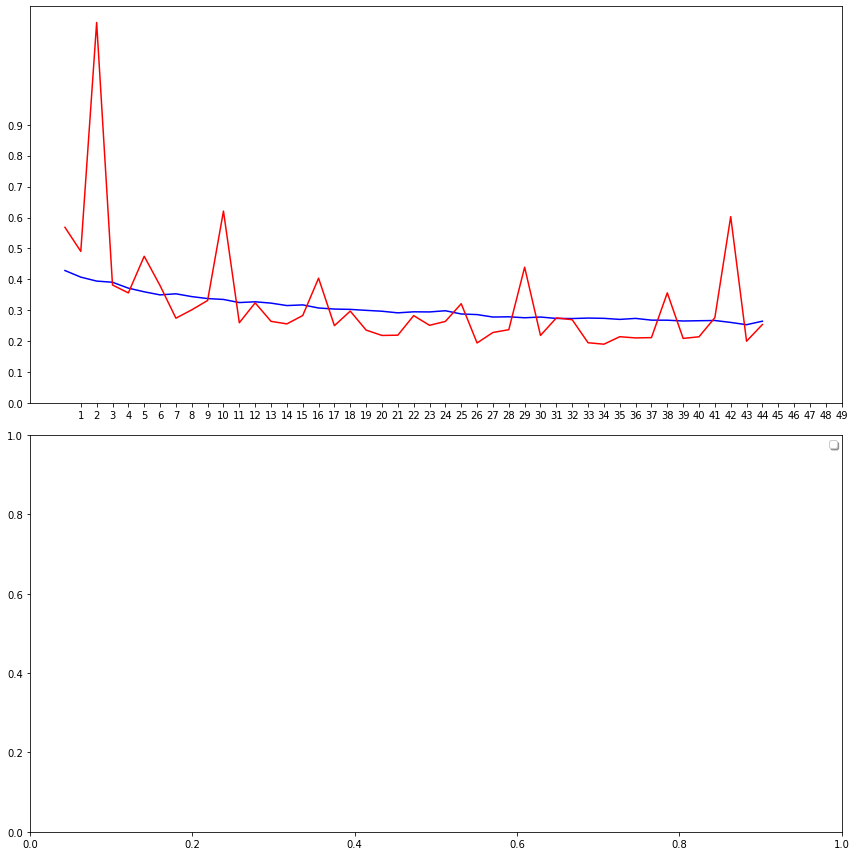

In [34]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,12))
ax1.plot(history.history['loss'],color='b',label='Training loss')
ax1.plot(history.history['val_loss'],color='r',label='validation loss')
ax1.set_xticks(np.arange(1,epochs,1))
ax1.set_yticks(np.arange(0,1,0.1))

# ax2.plot(history.history['acc'],color='b',label='Training accuracy')
# ax2.plot(history.history['val_acc'],color='r',label='validation accuracy')
# ax2.set_xticks(np.arange(1,epochs,1))

legend = plt.legend(loc='best',shadow=True)
plt.tight_layout()
plt.show()

Found 12500 validated image filenames.


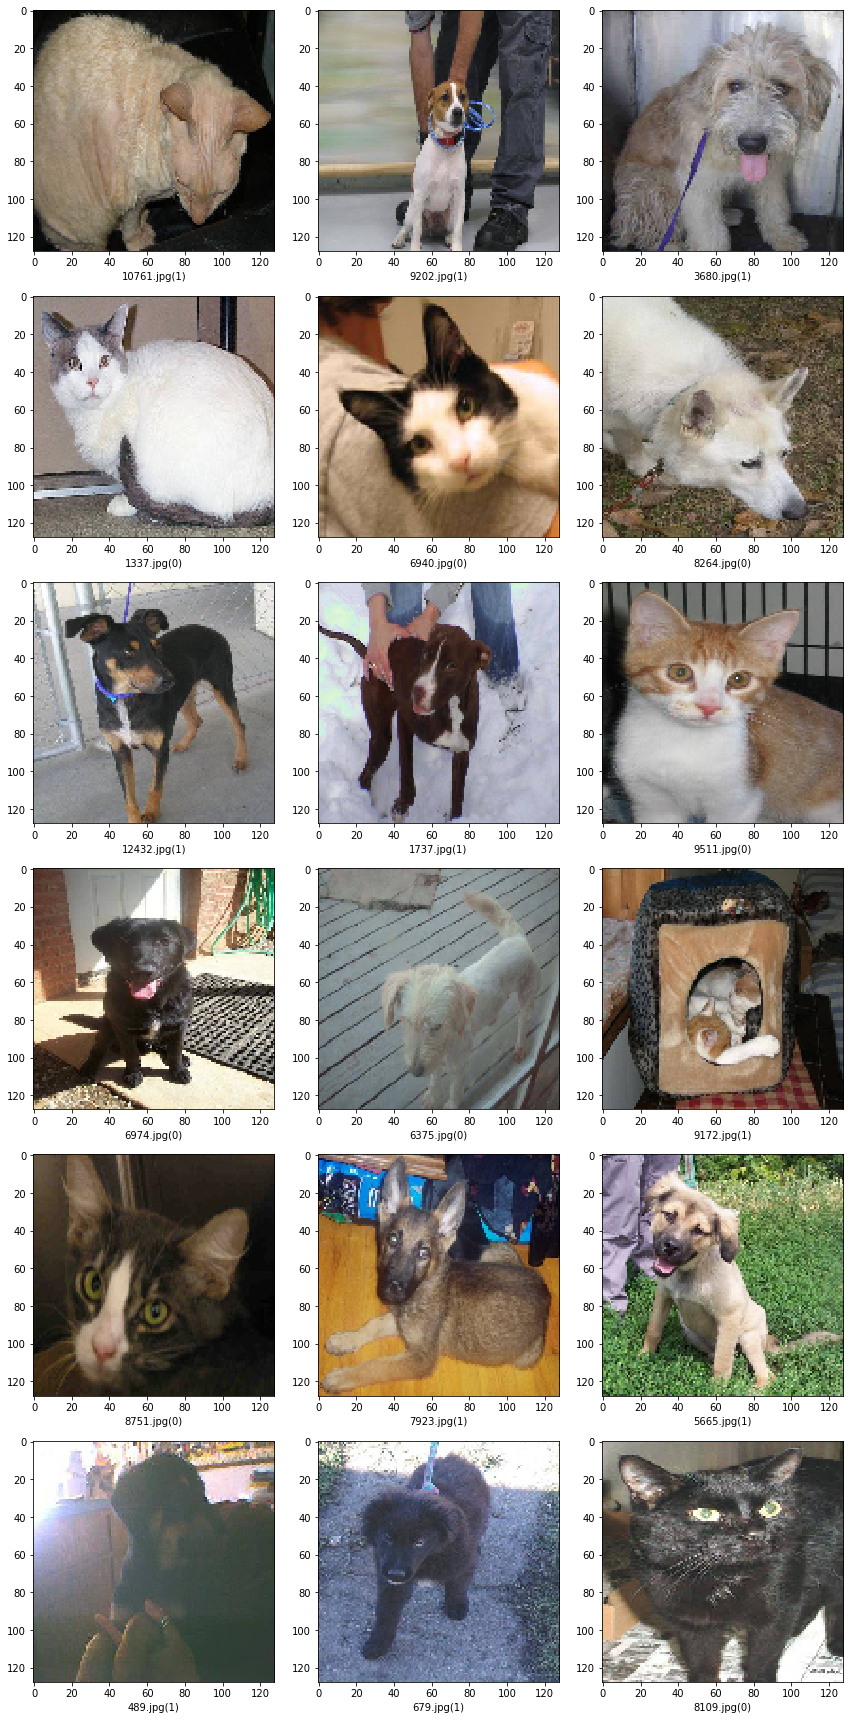

In [37]:
# Test를 해보장
test_filenames = os.listdir('./dogvscat/test1/')
test_df = pd.DataFrame({
    'filename':test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    './dogvscat/test1/',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

# 모델 예측
predict = model.predict_generator(test_generator,steps=np.ceil(nb_samples/batch_size))

# 평가 생성
# 확률이 큰 걸로 라벨을 붙여준다
test_df['category'] = np.argmax(predict,axis=-1)

# 레이블 변환
# 평가를 위해서 dog,cat으로 있던걸 다시 1,0으로 변환
# print(test_df['category'])
# test_df['category'] = test_df['category'].replace({'dog':1,'cat':0})

# 정답 확인!
# 강아지는 1 고양이는 0 이다
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12,24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('./dogvscat/test1/'+filename,target_size=IMAGE_SIZE)
    plt.subplot(6,3,index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + '{}'.format(category) + ')')
plt.tight_layout()
plt.show()